In [ ]:
# url= https://drive.google.com/file/d/1jOebB4F1E9SfJlsP0-qMDufB__8A4JrP/view?usp=sharing

# Replace YOUR_URL with the actual URL of your dataset
!gdown "https://drive.google.com/uc?id=1jOebB4F1E9SfJlsP0-qMDufB__8A4JrP"

# Verify the file is downloaded
!ls


Downloading...
From: https://drive.google.com/uc?id=1jOebB4F1E9SfJlsP0-qMDufB__8A4JrP
To: /content/countries.csv
100% 103M/103M [00:02<00:00, 37.3MB/s] 
countries.csv  sample_data


In [ ]:
import pandas as pd
from transformers import pipeline

# Load the dataset
file_path = 'countries.csv'  # Update with the actual path if necessary
df = pd.read_csv(file_path)

In [ ]:
df.head()

,speaker,date,title,contents,Party,cleaned_contents,tokens,normalized_tokens,frame_tokens,identified_countries,identified_nationalities,identified_regions,mapped_nationalities,mapped_regions,all_identified
0,Sir J. Anderson,2/6/1940,Eire Citizens (Immigration),I have had no representations from the police ...,Conservative Party,i have had no representations from the police ...,"['representation', 'police', 'contrary']","['representation', 'police', 'contrary']","{'Contributions': [], 'Crime': [], 'Culture': ...",[],[],[],[],[],[]
1,Sir J. Anderson,2/6/1940,Eire Citizens (Immigration),"No, Sir. Even if the principle underlying the ...",Conservative Party,no sir even if the principle underlying the ri...,"['sir', 'principle', 'underlie', 'right', 'hon...","['sir', 'principle', 'underlie', 'right', 'hon...","{'Contributions': [], 'Crime': [], 'Culture': ...",[],[],[],[],[],[]
2,Mr. M. MacDonald,2/14/1940,Palestine (Jewish Immigration),The steady improvement in the internal situati...,Labour Party,the steady improvement in the internal situati...,"['steady', 'improvement', 'internal', 'situati...","['steady', 'improvement', 'internal', 'situati...","{'Contributions': [], 'Crime': [], 'Culture': ...",['Palestine'],[],['Middle_East'],[],[],['Palestine']
3,Mr. MacDonald,2/14/1940,Palestine (Jewish Immigration),"The legal quota allowed something over 10,000 ...",Labour Party,the legal quota allowed something over jews to...,"['legal', 'quota', 'allow', 'jews', 'settle', ...","['legal', 'quota', 'allow', 'jew', 'settle', '...","{'Contributions': [], 'Crime': [], 'Culture': ...",['Palestine'],[],['Middle_East'],[],[],['Palestine']
4,Mr. MacDonald,2/14/1940,Palestine (Jewish Immigration),That is another question.,Labour Party,that is another question,['question'],['question'],"{'Contributions': [], 'Crime': [], 'Culture': ...",[],[],[],[],[],[]


In [ ]:
# Preview the dataset
print("Dataset Preview:")

# Example: Check column names
print("Columns in the dataset:", df.columns)

Dataset Preview:
Columns in the dataset: Index(['speaker', 'date', 'title', 'contents', 'Party', 'cleaned_contents',
       'tokens', 'normalized_tokens', 'frame_tokens', 'identified_countries',
       'identified_nationalities', 'identified_regions',
       'mapped_nationalities', 'mapped_regions', 'all_identified'],
      dtype='object')


In [ ]:
from transformers import pipeline
import torch
import pandas as pd

# Check GPU availability
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

# Initialize the sentiment analysis pipeline
classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment", device=device)

# Function to classify sentiments with truncation
def classify_sentiment(text, max_length=512):
    try:
        if not text or pd.isna(text):
            return None, None, None
        # Truncate text if it exceeds the model's max length
        truncated_text = text[:max_length]
        predictions = classifier(truncated_text)
        # Extract probabilities for each label
        anti_prob = next((pred['score'] for pred in predictions if pred['label'] == "LABEL_0"), 0)
        neutral_prob = next((pred['score'] for pred in predictions if pred['label'] == "LABEL_1"), 0)
        pro_prob = next((pred['score'] for pred in predictions if pred['label'] == "LABEL_2"), 0)
        return anti_prob, neutral_prob, pro_prob
    except Exception as e:
        print(f"Error processing text: {text}\n{e}")
        return None, None, None

# Load your dataset
df = pd.read_csv("countries.csv")

# Apply the sentiment analysis to `cleaned_contents` with progress
from tqdm import tqdm
tqdm.pandas()  # Enable progress bar for pandas apply
df['classification_probs'] = df['cleaned_contents'].progress_apply(classify_sentiment)

# Split probabilities into separate columns
df[['anti_prob', 'neutral_prob', 'pro_prob']] = pd.DataFrame(df['classification_probs'].tolist(), index=df.index)

# Assign a label based on the highest probability
df['tone_label'] = df[['anti_prob', 'neutral_prob', 'pro_prob']].idxmax(axis=1).str.replace('_prob', '')

# Drop intermediate column if unnecessary
#df = df.drop(columns=['classification_probs'])

# Save the updated dataset
output_file = "sentiment_analysis_results.csv"
df.to_csv(output_file, index=False)
print(f"Sentiment analysis results saved to {output_file}")

# Preview updated columns
print("Updated dataset preview:")
print(df.head())


Using device: GPU


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
100%|██████████| 33367/33367 [05:20<00:00, 104.17it/s]
<ipython-input-5-3709d441a85e>:41: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['tone_label'] = df[['anti_prob', 'neutral_prob', 'pro_prob']].idxmax(axis=1).str.replace('_prob', '')


Sentiment analysis results saved to sentiment_analysis_results.csv
Updated dataset preview:
            speaker       date                           title  \
0   Sir J. Anderson   2/6/1940     Eire Citizens (Immigration)   
1   Sir J. Anderson   2/6/1940     Eire Citizens (Immigration)   
2  Mr. M. MacDonald  2/14/1940  Palestine (Jewish Immigration)   
3     Mr. MacDonald  2/14/1940  Palestine (Jewish Immigration)   
4     Mr. MacDonald  2/14/1940  Palestine (Jewish Immigration)   

                                            contents               Party  \
0  I have had no representations from the police ...  Conservative Party   
1  No, Sir. Even if the principle underlying the ...  Conservative Party   
2  The steady improvement in the internal situati...        Labour Party   
3  The legal quota allowed something over 10,000 ...        Labour Party   
4                          That is another question.        Labour Party   

                                    cleaned_contents  

Country-wise Sentiment Analysis:
    identified_countries    anti_prob  neutral_prob     pro_prob  \
455                   []  3898.666450  13224.059233  4333.626822   
203          ['Ireland']    23.699959    109.776224    36.047597   
121           ['France']    29.852096     76.096748    26.909778   
189            ['India']    25.106238     74.353462    14.067979   
309         ['Pakistan']    14.890146     44.089109    12.720876   

       total_prob  anti_percent  neutral_percent  pro_percent  
455  21456.352505     18.170220        61.632373    20.197407  
203    169.523780     13.980315        64.755649    21.264036  
121    132.858621     22.469069        57.276485    20.254446  
189    113.527679     22.114641        65.493686    12.391673  
309     71.700130     20.767250        61.490975    17.741775  


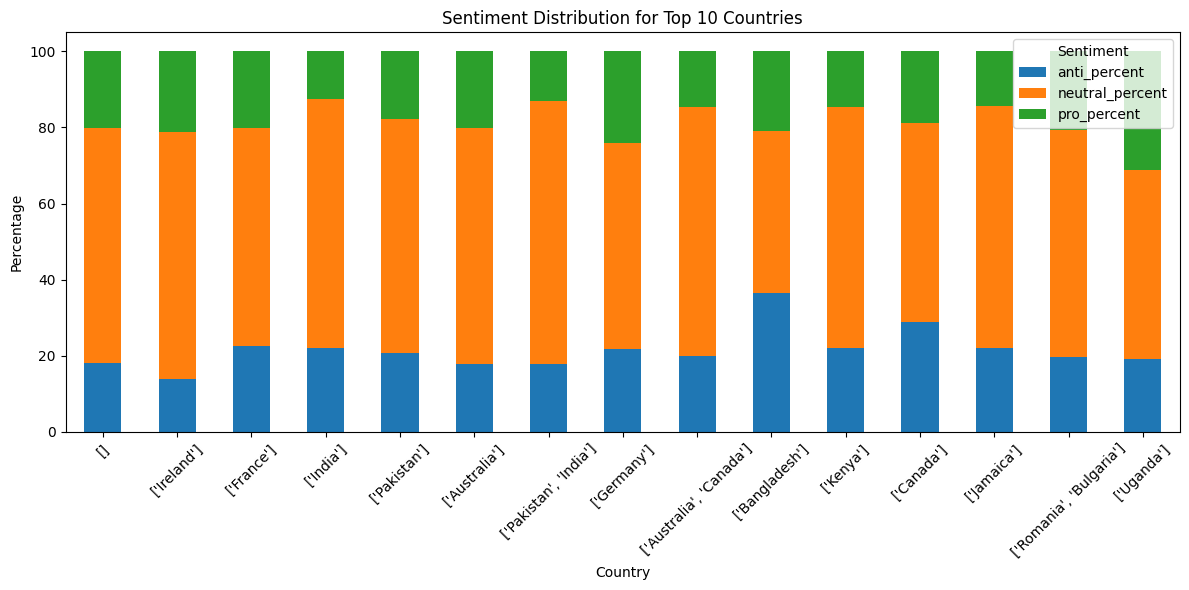

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that identified_countries is properly populated
if 'identified_countries' not in df.columns:
    raise ValueError("The column 'identified_countries' is missing in the dataset.")

# Explode identified_countries to create a row for each country per entry
df_exploded = df.explode('identified_countries')

# Filter out rows where identified_countries is NaN
df_exploded = df_exploded.dropna(subset=['identified_countries'])

# Group by country and aggregate sentiment probabilities
country_sentiment = (
    df_exploded.groupby('identified_countries')[['anti_prob', 'neutral_prob', 'pro_prob']]
    .sum()
    .reset_index()
)

# Calculate percentages for each sentiment type
country_sentiment['total_prob'] = (
    country_sentiment['anti_prob'] +
    country_sentiment['neutral_prob'] +
    country_sentiment['pro_prob']
)
country_sentiment['anti_percent'] = (country_sentiment['anti_prob'] / country_sentiment['total_prob']) * 100
country_sentiment['neutral_percent'] = (country_sentiment['neutral_prob'] / country_sentiment['total_prob']) * 100
country_sentiment['pro_percent'] = (country_sentiment['pro_prob'] / country_sentiment['total_prob']) * 100

# Sort by total probability for better visualization
country_sentiment = country_sentiment.sort_values(by='total_prob', ascending=False)

# Save the table for further analysis
country_sentiment.to_csv("country_sentiment_analysis.csv", index=False)

# Preview the table
print("Country-wise Sentiment Analysis:")
print(country_sentiment.head())

# Visualize the sentiment distribution for the top 10 countries
top_countries = country_sentiment.head(15)
fig, ax = plt.subplots(figsize=(12, 6))
top_countries.plot(
    x='identified_countries',
    y=['anti_percent', 'neutral_percent', 'pro_percent'],
    kind='bar',
    stacked=True,
    ax=ax
)
plt.title("Sentiment Distribution for Top 10 Countries")
plt.ylabel("Percentage")
plt.xlabel("Country")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


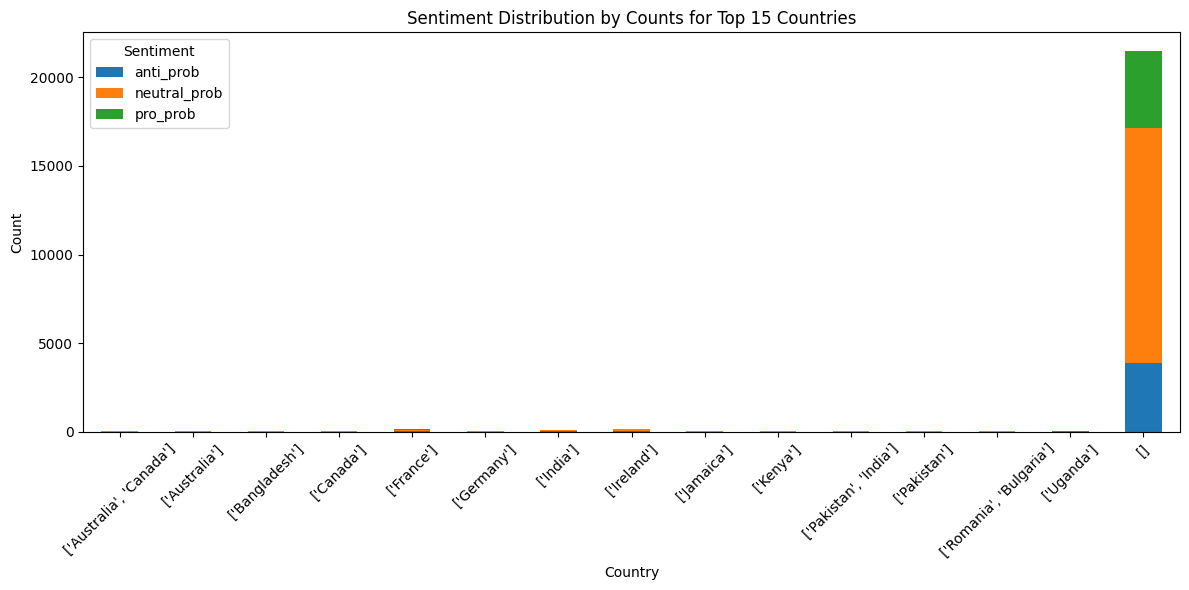

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Explode identified_countries to create a row for each country per entry
df_exploded = df.explode('identified_countries')

# Filter out rows where identified_countries is NaN
df_exploded = df_exploded.dropna(subset=['identified_countries'])

# Group by country and aggregate sentiment probabilities
country_sentiment = (
    df_exploded.groupby('identified_countries')[['anti_prob', 'neutral_prob', 'pro_prob']]
    .sum()
    .reset_index()
)

# Calculate total counts for sorting
country_sentiment['total_count'] = (
    country_sentiment['anti_prob'] +
    country_sentiment['neutral_prob'] +
    country_sentiment['pro_prob']
)

# Sort by total counts and select the top 15 countries
top_15_countries = country_sentiment.sort_values(by='total_count', ascending=False).head(15)

# Filter the exploded dataset to include only the top 15 countries for plotting
df_filtered = df_exploded[df_exploded['identified_countries'].isin(top_15_countries['identified_countries'])]

# Aggregate counts again but limited to the top 15 countries
final_aggregated_sentiment = (
    df_filtered.groupby('identified_countries')[['anti_prob', 'neutral_prob', 'pro_prob']]
    .sum()
    .reset_index()
)

# Plot real counts for the top 15 countries
fig, ax = plt.subplots(figsize=(12, 6))
final_aggregated_sentiment.plot(
    x='identified_countries',
    y=['anti_prob', 'neutral_prob', 'pro_prob'],
    kind='bar',
    stacked=True,
    ax=ax
)
plt.title("Sentiment Distribution by Counts for Top 15 Countries")
plt.ylabel("Count")
plt.xlabel("Country")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the updated table for future reference
final_aggregated_sentiment.to_csv("top_15_countries_sentiment_counts.csv", index=False)

# Display the updated table for user inspection
import ace_tools as tools; tools.display_dataframe_to_user(name="Top 15 Country Sentiments with Counts", dataframe=final_aggregated_sentiment)


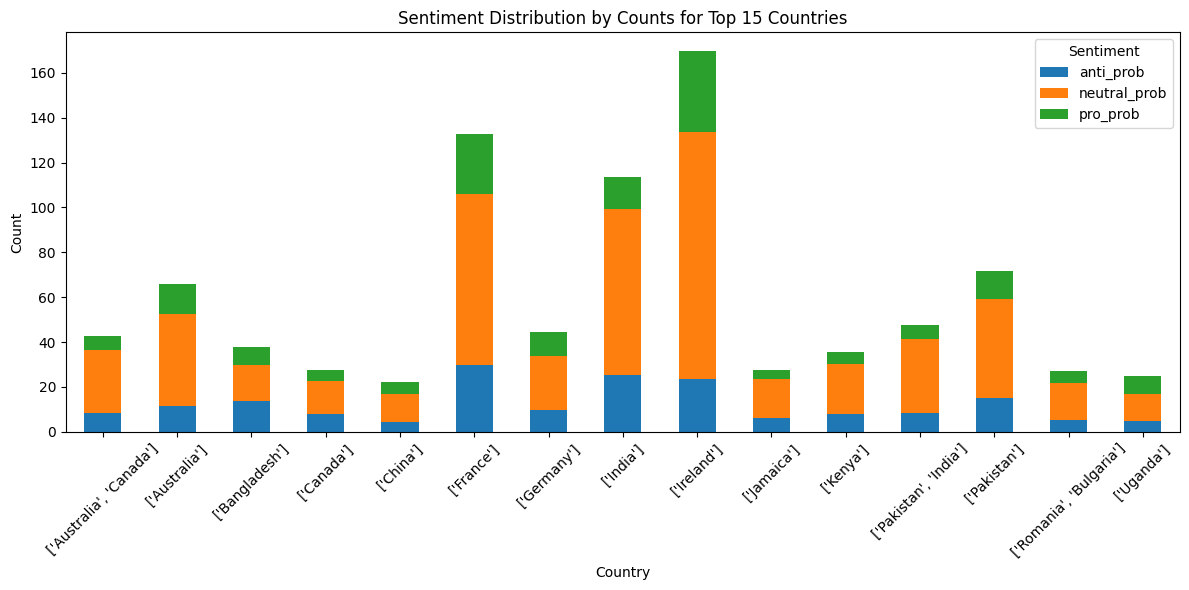

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Remove empty or invalid entries ([] in identified_countries)
df_exploded = df.explode('identified_countries')
df_exploded = df_exploded[df_exploded['identified_countries'] != '[]']
df_exploded = df_exploded.dropna(subset=['identified_countries'])

# Group by country and aggregate sentiment probabilities
country_sentiment = (
    df_exploded.groupby('identified_countries')[['anti_prob', 'neutral_prob', 'pro_prob']]
    .sum()
    .reset_index()
)

# Calculate total counts for sorting
country_sentiment['total_count'] = (
    country_sentiment['anti_prob'] +
    country_sentiment['neutral_prob'] +
    country_sentiment['pro_prob']
)

# Sort by total counts and select the top 15 countries
top_15_countries = country_sentiment.sort_values(by='total_count', ascending=False).head(15)

# Filter the dataset to include only the top 15 countries for plotting
df_filtered = df_exploded[df_exploded['identified_countries'].isin(top_15_countries['identified_countries'])]

# Aggregate counts again but limited to the top 15 countries
final_aggregated_sentiment = (
    df_filtered.groupby('identified_countries')[['anti_prob', 'neutral_prob', 'pro_prob']]
    .sum()
    .reset_index()
)

# Plot real counts for the top 15 countries
fig, ax = plt.subplots(figsize=(12, 6))
final_aggregated_sentiment.plot(
    x='identified_countries',
    y=['anti_prob', 'neutral_prob', 'pro_prob'],
    kind='bar',
    stacked=True,
    ax=ax
)
plt.title("Sentiment Distribution by Counts for Top 15 Countries")
plt.ylabel("Count")
plt.xlabel("Country")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the updated table for future reference
final_aggregated_sentiment.to_csv("top_15_countries_sentiment_counts_cleaned.csv", index=False)

# Display the updated table for user inspection
import ace_tools as tools; tools.display_dataframe_to_user(name="Top 15 Country Sentiments with Counts (Cleaned)", dataframe=final_aggregated_sentiment)


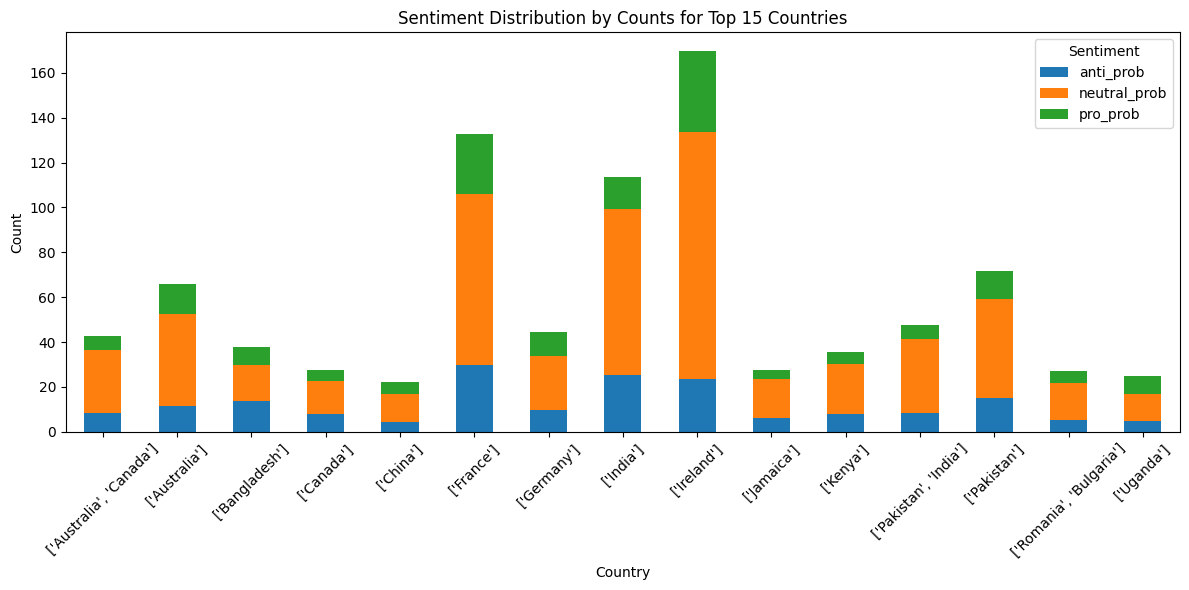

Sentiment counts for top 15 countries saved to: top_15_countries_sentiment_counts_cleaned.csv
Top 15 Country Sentiments with Counts (Cleaned):
       identified_countries  anti_prob  neutral_prob   pro_prob
0   ['Australia', 'Canada']   8.539797     27.822953   6.281099
1             ['Australia']  11.685170     40.731656  13.268116
2            ['Bangladesh']  13.839752     16.143856   7.918906
3                ['Canada']   7.958908     14.507906   5.227667
4                 ['China']   4.174532     12.567102   5.637895
5                ['France']  29.852096     76.096748  26.909778
6               ['Germany']   9.637338     24.154815  10.720928
7                 ['India']  25.106238     74.353462  14.067979
8               ['Ireland']  23.699959    109.776224  36.047597
9               ['Jamaica']   6.043915     17.398117   3.908819
10                ['Kenya']   7.854923     22.492586   5.200225
11    ['Pakistan', 'India']   8.475499     32.795585   6.260562
12             ['Pakistan

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Remove empty or invalid entries ([] in identified_countries)
df_exploded = df.explode('identified_countries')
df_exploded = df_exploded[df_exploded['identified_countries'] != '[]']
df_exploded = df_exploded.dropna(subset=['identified_countries'])

# Group by country and aggregate sentiment probabilities
country_sentiment = (
    df_exploded.groupby('identified_countries')[['anti_prob', 'neutral_prob', 'pro_prob']]
    .sum()
    .reset_index()
)

# Calculate total counts for sorting
country_sentiment['total_count'] = (
    country_sentiment['anti_prob'] +
    country_sentiment['neutral_prob'] +
    country_sentiment['pro_prob']
)

# Sort by total counts and select the top 15 countries
top_15_countries = country_sentiment.sort_values(by='total_count', ascending=False).head(15)

# Filter the dataset to include only the top 15 countries for plotting
df_filtered = df_exploded[df_exploded['identified_countries'].isin(top_15_countries['identified_countries'])]

# Aggregate counts again but limited to the top 15 countries
final_aggregated_sentiment = (
    df_filtered.groupby('identified_countries')[['anti_prob', 'neutral_prob', 'pro_prob']]
    .sum()
    .reset_index()
)

# Plot real counts for the top 15 countries
fig, ax = plt.subplots(figsize=(12, 6))
final_aggregated_sentiment.plot(
    x='identified_countries',
    y=['anti_prob', 'neutral_prob', 'pro_prob'],
    kind='bar',
    stacked=True,
    ax=ax
)
plt.title("Sentiment Distribution by Counts for Top 15 Countries")
plt.ylabel("Count")
plt.xlabel("Country")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the updated table for future reference
output_file = "top_15_countries_sentiment_counts_cleaned.csv"
final_aggregated_sentiment.to_csv(output_file, index=False)
print(f"Sentiment counts for top 15 countries saved to: {output_file}")

# Display the updated DataFrame
print("Top 15 Country Sentiments with Counts (Cleaned):")
print(final_aggregated_sentiment)


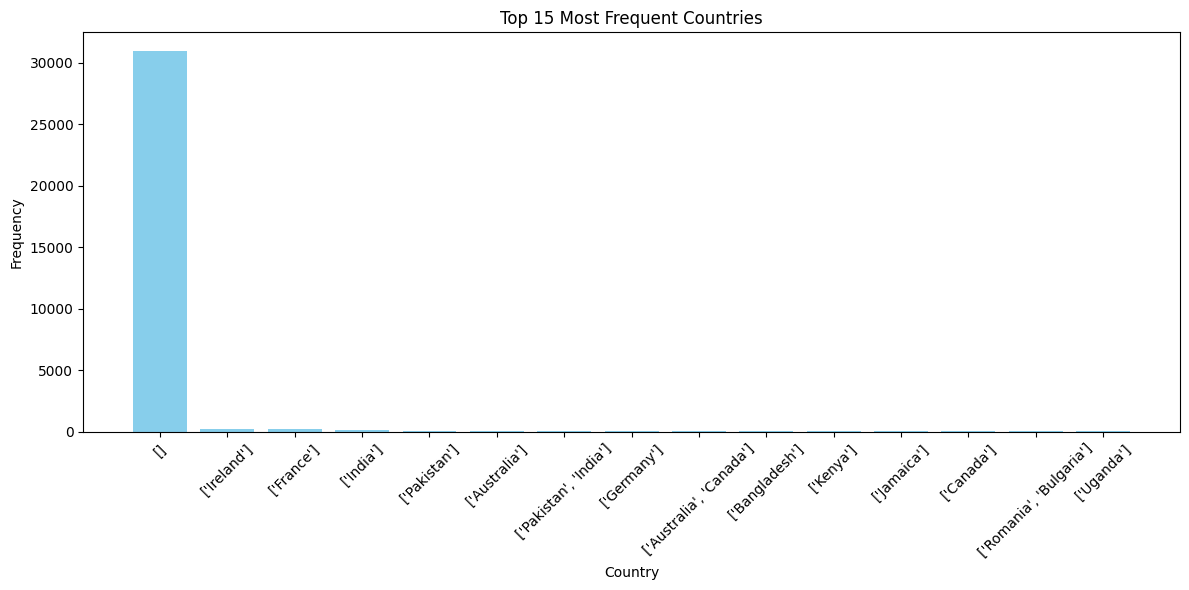

Top 15 countries with frequencies saved to: top_15_countries_frequencies.csv
Top 15 Most Frequent Countries:
                    Country  Frequency
0                        []      30929
1               ['Ireland']        248
2                ['France']        205
3                 ['India']        175
4              ['Pakistan']        105
5             ['Australia']         99
6     ['Pakistan', 'India']         75
7               ['Germany']         67
8   ['Australia', 'Canada']         65
9            ['Bangladesh']         57
10                ['Kenya']         51
11              ['Jamaica']         41
12               ['Canada']         41
13  ['Romania', 'Bulgaria']         38
14               ['Uganda']         37


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Explode the 'identified_countries' column to count occurrences of each country
df_exploded = df.explode('identified_countries')
df_exploded = df_exploded.dropna(subset=['identified_countries'])  # Drop rows with NaN countries

# Count the occurrences of each country
country_counts = df_exploded['identified_countries'].value_counts().reset_index()
country_counts.columns = ['Country', 'Frequency']

# Get the top 15 most frequent countries
top_15_countries = country_counts.head(15)

# Plot the top 15 countries by frequency
plt.figure(figsize=(12, 6))
plt.bar(top_15_countries['Country'], top_15_countries['Frequency'], color='skyblue')
plt.title('Top 15 Most Frequent Countries')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the top 15 countries to a CSV file
output_file = "top_15_countries_frequencies.csv"
top_15_countries.to_csv(output_file, index=False)
print(f"Top 15 countries with frequencies saved to: {output_file}")

# Display the top 15 countries with their frequencies
print("Top 15 Most Frequent Countries:")
print(top_15_countries)


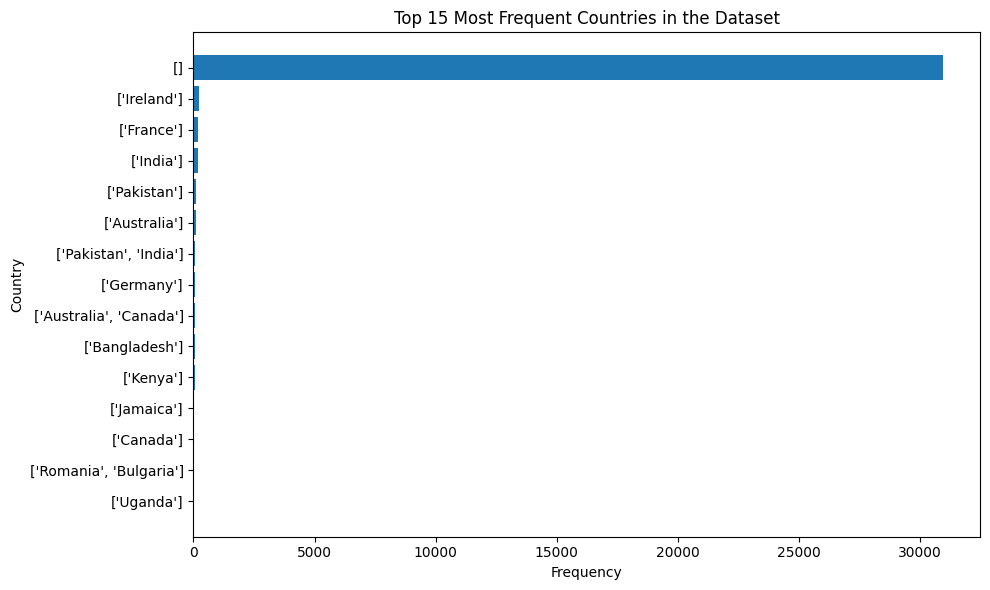

Top 15 countries table saved to: top_15_countries_with_frequencies.csv
Top 15 Most Frequent Countries with Frequencies:
                    Country  Frequency
0                        []      30929
1               ['Ireland']        248
2                ['France']        205
3                 ['India']        175
4              ['Pakistan']        105
5             ['Australia']         99
6     ['Pakistan', 'India']         75
7               ['Germany']         67
8   ['Australia', 'Canada']         65
9            ['Bangladesh']         57
10                ['Kenya']         51
11              ['Jamaica']         41
12               ['Canada']         41
13  ['Romania', 'Bulgaria']         38
14               ['Uganda']         37


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the `df` DataFrame already contains the `identified_countries` column

# Flatten the identified_countries column to calculate frequency
all_countries = df['identified_countries'].explode().dropna()
country_counts = all_countries.value_counts().reset_index()
country_counts.columns = ['Country', 'Frequency']

# Filter for the top 15 most frequent countries
top_15_countries = country_counts.head(15)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.barh(top_15_countries['Country'][::-1], top_15_countries['Frequency'][::-1])
plt.title("Top 15 Most Frequent Countries in the Dataset")
plt.xlabel("Frequency")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Save the table as a CSV file for reference
output_csv = "top_15_countries_with_frequencies.csv"
top_15_countries.to_csv(output_csv, index=False)
print(f"Top 15 countries table saved to: {output_csv}")

# Display the table directly in the console
print("Top 15 Most Frequent Countries with Frequencies:")
print(top_15_countries)


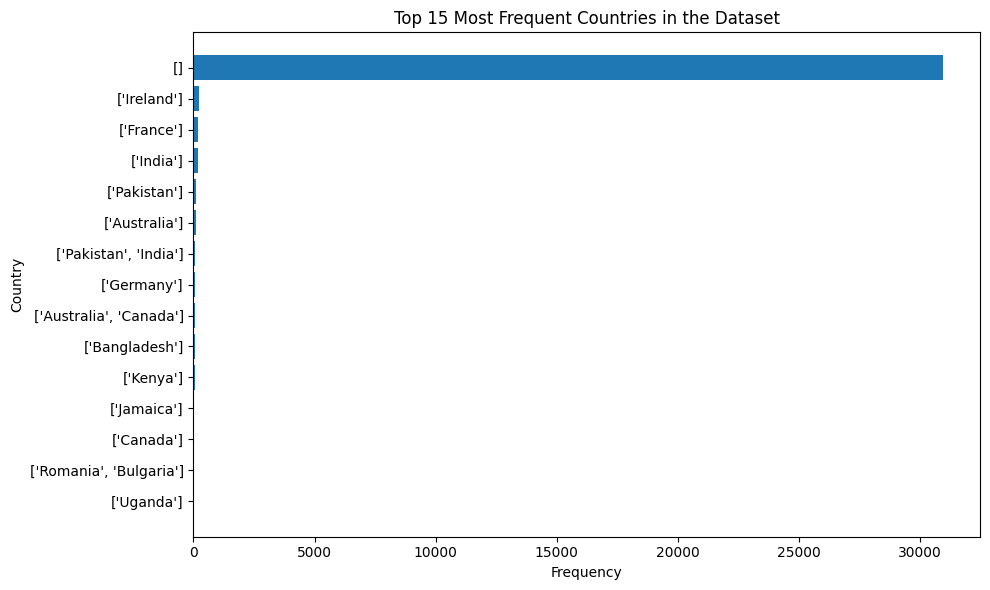

Top 15 countries table saved to: top_15_countries_with_frequencies.csv
Top 15 Most Frequent Countries with Frequencies:
                    Country  Frequency
0                        []      30929
1               ['Ireland']        248
2                ['France']        205
3                 ['India']        175
4              ['Pakistan']        105
5             ['Australia']         99
6     ['Pakistan', 'India']         75
7               ['Germany']         67
8   ['Australia', 'Canada']         65
9            ['Bangladesh']         57
10                ['Kenya']         51
11              ['Jamaica']         41
12               ['Canada']         41
13  ['Romania', 'Bulgaria']         38
14               ['Uganda']         37


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the `df` DataFrame already contains the `identified_countries` column

# Flatten the identified_countries column to calculate frequency
all_countries = df['identified_countries'].explode().dropna()
country_counts = all_countries.value_counts().reset_index()
country_counts.columns = ['Country', 'Frequency']

# Filter for the top 15 most frequent countries
top_15_countries = country_counts.head(15)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.barh(top_15_countries['Country'][::-1], top_15_countries['Frequency'][::-1])
plt.title("Top 15 Most Frequent Countries in the Dataset")
plt.xlabel("Frequency")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Save the table as a CSV file for reference
output_csv = "top_15_countries_with_frequencies.csv"
top_15_countries.to_csv(output_csv, index=False)
print(f"Top 15 countries table saved to: {output_csv}")

# Display the table directly in the console
print("Top 15 Most Frequent Countries with Frequencies:")
print(top_15_countries)


In [ ]:
from google.colab import files

# Download the updated dataset
output_file = "sentiment_analysis_results.csv"
files.download(output_file)
print("Downloaded Successfully!!!")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded Successfully!!!
